In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir('/content/gdrive/MyDrive/Colab_app/M3E2/dragonnet_baseline')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve

In [7]:
from CompBioAndSimulated_Datasets.simulated_data_multicause import copula_simulated_data, gwas_simulated_data

In [8]:
SEED = 5

In [9]:
sdata_gwas = gwas_simulated_data(seed=SEED)
X, y, y01, treatment_columns, treatment_effects, group  = sdata_gwas.generate_samples()

GWAS simulated data initialized!
... Treatments:  10 [0.002, 0.0005, 0.0015, 0.0015, 0.002, 0.0014, 0.0019, 0.0019, 0.0016, 0.0018]
... Confounders:  90
... Target (y) : 0.4384
... Sample Size: 10000
 Data Simulation Done!


In [10]:
idx_1 = np.where(np.sum(X.values[:, treatment_columns], axis=1) == 1)[0]

In [11]:
X = X.iloc[idx_1]
y = y[:, idx_1]
y01 = y01[idx_1]

In [12]:
for i in range(10):
    col = 'causal_' + str(i)
    print(col + ': ', X[col].values.sum())

causal_0:  366
causal_1:  391
causal_2:  162
causal_3:  298
causal_4:  284
causal_5:  354
causal_6:  291
causal_7:  247
causal_8:  379
causal_9:  387


In [13]:
print(y01.sum())

1425


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y01, test_size=0.33, random_state=SEED)

# Dataset

In [15]:
class CI_data(Dataset):
    def __init__(self, causal, noncausal, outcome, dosage=None):
        self.causal = causal.astype(np.float32)
        self.noncausal = noncausal.astype(np.float32)
        self.target = outcome.astype(np.float32)

        if dosage is None:
            dosage = np.zeros([len(self.target), 1])
        self.dosage = dosage.astype(np.float32)

    def __getitem__(self, index):
        t, c, y, e = self.causal[index], self.noncausal[index], self.target[index], self.dosage[index]
        return t, c, y, e

    def __len__(self):
        return len(self.target)

# Model

In [16]:
# calculate p(T_k)
def cal_prior(causal):
    N = causal.shape[0]
    prior_list = []
    for k in range(causal.shape[1]):
        pos_num = len(np.where(causal[:, k] == 1)[0])
        prior_k = pos_num / N  # prior_k = p(T_k=1)
        prior_list.append(prior_k)

    prior = torch.tensor(np.array(prior_list))  # shape = [num_treatment]
    return prior  # shape = [num_treatment]


# get theta_Tk using logistic regression
def fit_theta(encoded, causal):
    theta_list = []
    for k in range(causal.shape[1]):
        lr = LogisticRegression(C=0.001, penalty='l2', solver='lbfgs', tol=1e-4, fit_intercept=False)
        x_train = encoded.cpu().detach().numpy()  # phi(x_n)
        y_train = causal[:, k].cpu().detach().numpy()  # binary treatment 0/1
        lr.fit(x_train, y_train)
        theta_k = lr.coef_
        theta_list.append(torch.tensor(theta_k.astype(np.float32)))
    return theta_list


# cross-entropy loss between P(T_K) and P(T_K|Phi)
class L_ce(nn.Module):
    def __init__(self):
        super(L_ce, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, encoded, causal, prior):
        # binary treatment
        # prior.shape = [num_treatment]
        # theta_list = list of theta_Tk
        
        theta_list = fit_theta(encoded, causal)

        batch_size = encoded.shape[0]
        num_treatment = prior.shape[0]
        
        posterior = []
        exp_sum = torch.zeros([batch_size]).to(self.device)
        for k in range(num_treatment):
            theta_Tk = theta_list[k].to(self.device)
            posterior_k = torch.mm(encoded, torch.transpose(theta_Tk, 0, 1))
            posterior_k = nn.Sigmoid()(posterior_k).view(-1)  # [batchsize]
            posterior.append(posterior_k)
            exp_sum += torch.exp(posterior_k)
        
        ce = torch.zeros([batch_size]).to(self.device)
        for k in range(num_treatment):
            prior_k = prior[k].repeat(batch_size)  # [batchsize]
            posterior_k = posterior[k] # [batchsize]
            ce += -(prior_k * posterior_k - prior_k * torch.log(exp_sum))

        return torch.mean(ce)

In [17]:
# mean-squared loss | reconstruction loss between ori_x and rec_x
class L_ae(nn.Module):
    def __init__(self):
        super(L_ae, self).__init__()
        
    def forward(self, ori_x, rec_x):
        criterion = torch.nn.MSELoss(reduction='mean')
        return criterion(ori_x, rec_x)

In [18]:
# regularizer term
class L_21(nn.Module):
    def __init__(self):
        super(L_21, self).__init__()
        
    def forward(self, phi_x, t):
        L = phi_x.shape[1]
        K = t.shape[1]
        mu = []
        
        # ==== compute matrix M_D ====

        # ---- sol2: ignore the missing treatments ----
        valid_K = 0
        for i in range(K):
            phi_i = phi_x[t[:, i] == 1]
            if phi_i.shape[0] > 0:
                mu_i = torch.mean(phi_i, dim=0)
                mu.append(mu_i)
                valid_K = valid_K + 1

        columns = []
        for i in range(valid_K):
            for j in range(valid_K):
                if (i == j):
                    continue
                col = (mu[i] - mu[j]) / (L * valid_K * (valid_K - 1))
                columns.append(col)
                
        M_D = torch.cat(columns).reshape(valid_K * (valid_K - 1), L)
        return torch.sum(torch.sqrt(torch.sum(torch.pow(M_D, 2), dim=1))) 

In [19]:
# prediction loss | root mean square error
class L_RMSE(nn.Module):
    def __init__(self):
        super(L_RMSE, self).__init__()

    def forward(self, pred, truth):
        return torch.sqrt(torch.mean(torch.pow(pred - truth, 2)))

In [20]:
# prediction loss | cross entropy error
class L_BIN(nn.Module):
    def __init__(self):
        super(L_BIN, self).__init__()

    def forward(self, pred, truth):
        criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        # criterion = torch.nn.BCELoss(reduction='mean')
        return criterion(pred, truth)

In [21]:
class total_loss_con(nn.Module):
    def __init__(self, beta, gamma, lamda):
        super(total_loss_con, self).__init__()
        self.b = beta
        self.g = gamma
        self.l = lamda
    
    def forward(self, t, prior, ori_x, phi_x, rec_x, pred, truth):
        c1 = L_ce()
        loss_ce = c1(phi_x, t, prior)
        c2 = L_ae()
        loss_ae = c2(ori_x, rec_x)
        c3 = L_21()
        loss_reg = c3(phi_x, t)
        c4 = L_RMSE()
        loss_rmse = c4(pred, truth)
        
        total_loss = loss_ce + self.b * loss_ae + self.g * loss_reg + self.l * loss_rmse
        
        return loss_ce, loss_ae, loss_reg, loss_rmse, total_loss

In [22]:
class total_loss_bin(nn.Module):
    def __init__(self, beta, gamma, lamda):
        super(total_loss_bin, self).__init__()
        self.b = beta
        self.g = gamma
        self.l = lamda
    
    def forward(self, t, prior, ori_x, phi_x, rec_x, pred, truth):
        c1 = L_ce()
        loss_ce = c1(phi_x, t, prior)
        c2 = L_ae()
        loss_ae = c2(ori_x, rec_x)
        c3 = L_21()
        loss_reg = c3(phi_x, t)
        c4 = L_BIN()
        loss_bin = c4(pred, truth)
        
        total_loss = loss_ce + self.b * loss_ae + self.g * loss_reg + self.l * loss_bin
        
        return loss_ce, loss_ae, loss_reg, loss_bin, total_loss

In [23]:
class autoencoder(nn.Module):
    def __init__(self, num_covs, num_feats,
                 enc_layers, enc_nodes, dec_layers, dec_nodes):
        assert len(enc_nodes) + 1 == enc_layers
        assert len(dec_nodes) + 1 == dec_layers

        super(autoencoder, self).__init__()

        # encoder
        enc_nodes = [num_covs] + enc_nodes + [num_feats]
        enc_modules = []
        for i in range(enc_layers):
            enc_modules.append(nn.Linear(enc_nodes[i], enc_nodes[i + 1]))
            enc_modules.append(nn.PReLU())
        self.encoder = nn.Sequential(*enc_modules)

        # decoder
        dec_nodes = [num_feats] + dec_nodes + [num_covs]
        dec_modules = []
        for i in range(enc_layers):
            dec_modules.append(nn.Linear(dec_nodes[i], dec_nodes[i + 1]))
            dec_modules.append(nn.PReLU())
        self.decoder = nn.Sequential(*dec_modules)

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

In [24]:
class sub_net(nn.Module):
    def __init__(self, num_feats, num_treats, hidden_layers=3, hidden_nodes=100):
        super(sub_net, self).__init__()
        self.hidden_layers = hidden_layers
        self.linear_in = nn.Linear(num_feats + num_treats, hidden_nodes)
        self.linear_hidden = nn.Linear(hidden_nodes, hidden_nodes)
        self.linear_out = nn.Linear(hidden_nodes, 1)

    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.linear_hidden(x))
        x = self.linear_out(x)
        return x

In [25]:
class HiCI_DNN(nn.Module):
    def __init__(self, num_treatments, num_covariates, num_features, num_dosages,
                 encoder_layers, decoder_layers, outcome_layers, 
                 encoder_nodes, decoder_nodes, outcome_nodes):
        super(HiCI_DNN, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.K = num_treatments
        self.P = num_covariates
        self.L = num_features
        self.E = num_dosages

        self.decorrelation_net = autoencoder(num_covs=self.P, num_feats=self.L,
                                             enc_layers=encoder_layers, dec_layers=decoder_layers,
                                             enc_nodes=encoder_nodes, dec_nodes=decoder_nodes).to(self.device)

        self.regression_net = []
        for i in range(self.E):
            self.regression_net.append(sub_net(num_feats=self.L, num_treats=self.K,
                                               hidden_layers=outcome_layers, hidden_nodes=outcome_nodes).to(self.device))

    def forward(self, treatments, covariates, dosages):
        encoded, decoded = self.decorrelation_net(covariates)
        embedding = torch.cat([encoded, treatments], dim=1)
        pred_y = torch.zeros([embedding.shape[0], 1]).to(self.device)
        for e in range(self.E):
            output_e = self.regression_net[e](embedding)
            pred_y += (dosages == e) * output_e
        return encoded, decoded, pred_y

In [26]:
def weights_init(mod):
    classname=mod.__class__.__name__
    # print(classname)
    if classname.find('Linear')!= -1:
        mod.weight.data.normal_()

# train

In [27]:
class HiCI():
    def __init__(self, X_train, X_test, y_train, y_test, treatments_columns, 
                 dosage_level=1, dosage_train=None, dosage_test=None):
        super(HiCI, self).__init__()
        self.X_train = X_train.values
        self.X_test = X_test.values
        self.y_train = y_train.reshape(-1, 1)
        self.y_test = y_test.reshape(-1, 1)
        self.treatments_columns = treatments_columns
        self.covariates_columns = [col for col in list(range(X_train.shape[1])) if col not in treatments_columns]
        self.dosage_level = dosage_level
        self.dosage_train = dosage_train
        self.dosage_test = dosage_test
        self.model = None
        self.ate = None
        self.f1_test = None
        self.test_output_list = []
        self.train_output_list = []
        self.all_output_list = []
        print('Running HiCI')

    def fit(self, type_target, batch_size=128, total_epochs=100, lr=0.001, lr_decay=0.6, ite_per_decay=1, weight_decay=0.0,
            encoder_layers=4, decoder_layers=4, outcome_layers=3, encoder_nodes=[64, 32, 16], decoder_nodes=[16, 32, 64], 
            encoded_dim=8, outcome_nodes=100, l2_reg=0.01, val_split=0.2, num_workers=0, normal_initialize=False,
            print_=True, plot_loss_=True):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("using device:", device)
        
        # create train_val dataset and test dataset
        train_val_set = CI_data(self.X_train[:, self.treatments_columns], self.X_train[:, self.covariates_columns],
                                self.y_train, self.dosage_train)
        test_set = CI_data(self.X_test[:, self.treatments_columns], self.X_test[:, self.covariates_columns],
                           self.y_test, self.dosage_test)
        # split the train_val into train set and val set
        val_size = int(train_val_set.__len__() * val_split)
        train_size = train_val_set.__len__() - val_size
        train_set, val_set = torch.utils.data.random_split(train_val_set, [train_size, val_size])
        
        # data loaders
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # train
        model = HiCI_DNN(num_treatments=len(self.treatments_columns), 
                         num_covariates=len(self.covariates_columns), 
                         num_features=encoded_dim,
                         num_dosages=self.dosage_level,
                         encoder_layers=encoder_layers, decoder_layers=decoder_layers, outcome_layers=outcome_layers,
                         encoder_nodes=encoder_nodes, decoder_nodes=decoder_nodes, outcome_nodes=outcome_nodes)
        if normal_initialize:
            print('initialize parameters using random normal distribution')
            model.apply(weights_init)
        
        if type_target == 'binary':
            criterion = total_loss_bin(beta=1, gamma=1, lamda=1)
        else:
            criterion = total_loss_con(beta=1, gamma=1, lamda=1)
        
        if torch.cuda.is_available():
            model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=1e-05,
                                                         eps=1e-05)
        # early_stopping = EarlyStopping(patience=patience, verbose=True)

        train_loss_values = []
        val_loss_values = []
        
        train_ce_loss = []
        train_ae_loss = []
        train_reg_loss = []
        train_pred_loss = []
        
        prior = cal_prior(self.X_train[:, self.treatments_columns]).to(device)
        for epoch in range(total_epochs):
            # ===== training =====
            train_running_loss = 0.0
            train_running_loss_ce = 0.0
            train_running_loss_ae = 0.0
            train_running_loss_reg = 0.0
            train_running_loss_pred = 0.0
            
            model.train()
            for i, data in enumerate(train_loader, 0):
                causal, noncausal, true_y, dosage = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                
                optimizer.zero_grad()
                encoded, decoded, pred_y = model(causal, noncausal, dosage)
                

                try:
                    l_ce, l_ae, l_reg, l_pred, loss = criterion(t=causal, prior=prior,
                                                                ori_x=noncausal, phi_x=encoded, rec_x=decoded,
                                                                pred=pred_y, truth=true_y)
                except ValueError as err:
                    # print("ValueError: {0}, skip this batch".format(err))
                    continue

                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()

                train_running_loss_ce += l_ce.item()
                train_running_loss_ae += l_ae.item()
                train_running_loss_reg += l_reg.item()
                train_running_loss_pred += l_pred.item()
                    

            scheduler.step(train_running_loss)
            train_loss_values.append(train_running_loss / (i + 1))
            
            train_ce_loss.append(train_running_loss_ce / (i + 1))
            train_ae_loss.append(train_running_loss_ae / (i + 1))
            train_reg_loss.append(train_running_loss_reg / (i + 1))
            train_pred_loss.append(train_running_loss_pred / (i + 1))

            # ===== validation =====
            val_running_loss = 0.0
            model.eval()
            for i, data in enumerate(val_loader, 0):
                causal, noncausal, true_y, dosage = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                encoded, decoded, pred_y = model(causal, noncausal, dosage)
                
                try:
                    l_ce, l_ae, l_reg, l_pred, loss = criterion(t=causal, prior=prior,
                                                                ori_x=noncausal, phi_x=encoded, rec_x=decoded,
                                                                pred=pred_y, truth=true_y)
                except ValueError as err:
                    # print("ValueError: {0}, skip this batch".format(err))
                    continue
                
                val_running_loss += loss.item()
                
            val_loss_values.append(val_running_loss / (i + 1))

        print("Finishing Training")
        
        if plot_loss_:
            plt.figure(figsize=(12, 16))
            plt.subplot(3, 2, 1)
            plt.plot(train_loss_values)
            plt.plot(val_loss_values)
            plt.legend(["train", "val"])

            plt.subplot(3, 2, 3)
            plt.plot(train_ce_loss)
            plt.legend(["CE"])
            plt.subplot(3, 2, 4)
            plt.plot(train_ae_loss)
            plt.legend(["AE"])
            plt.subplot(3, 2, 5)
            plt.plot(train_reg_loss)
            plt.legend(["REG"])
            plt.subplot(3, 2, 6)
            plt.plot(train_pred_loss)
            plt.legend(["PRED"])
                    
        # test
        model.eval()
        # on training set
        train_output = []
        train_val_loader = DataLoader(train_val_set, batch_size=batch_size, 
                                      shuffle=False, num_workers=num_workers)
        with torch.no_grad():
            for i, data in enumerate(train_val_loader, 0):
                causal, noncausal, true_y, dosage = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                encoded, decoded, pred_y = model(causal, noncausal, dosage)
                train_output.append(pred_y.cpu().numpy())
        y_train_pred = np.concatenate(train_output)


        # on test set
        test_output = []
        test_loader = DataLoader(test_set, batch_size=batch_size, 
                                 shuffle=False, num_workers=num_workers)
        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                causal, noncausal, true_y, dosage = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                encoded, decoded, pred_y = model(causal, noncausal, dosage)
                test_output.append(pred_y.cpu().numpy())
        y_test_pred = np.concatenate(test_output)
        
        self.model = model
                            
        thhold = self.Find_Optimal_Cutoff(self.y_train, y_train_pred)
        y_train_pred01 = [0 if item < thhold else 1 for item in y_train_pred]
        y_test_pred01 = [0 if item < thhold else 1 for item in y_test_pred]
        if print_:
            print('... Evaluation:')
            print('... Training set: F1 - ', f1_score(self.y_train, y_train_pred01))
            print('...... confusion matrix: ', confusion_matrix(self.y_train, y_train_pred01).ravel())

            print('... Testing set: F1 - ', f1_score(self.y_test, y_test_pred01))
            print('...... confusion matrix: ', confusion_matrix(self.y_test, y_test_pred01).ravel())

    
    def cate(self, dataset='all'):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if dataset == 'train':
            X = self.X_train
            y = self.y_train
        if dataset == 'test':
            X = self.X_test
            y = self.y_test
        if dataset == 'all':
            X = np.concatenate([self.X_train, self.X_test], axis=0)
            y = np.concatenate([self.y_train, self.y_test], axis=0)
            
        dataset = CI_data(X[:, self.treatments_columns], X[:, self.covariates_columns], y, None)
        dataloader = DataLoader(dataset, batch_size=X.shape[0], shuffle=False, num_workers=0)
        
        model = self.model
        outcome = []
        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                causal, noncausal, true_y, dosage = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                
                encoded, decoded, pred_y = model(causal, noncausal, dosage)
                outcome.append(pred_y.cpu().numpy())

        outcome = np.concatenate(outcome)
        
        self.cate = []
        for i in range(len(self.treatments_columns)):
            t_col = self.treatments_columns[i]
            
            q_t1 = np.mean(outcome[np.where(X[:, t_col] == 1)[0]])
            q_t0 = np.mean(outcome[np.where(X[:, t_col] == 0)[0]])
                
            self.cate.append(q_t1 - q_t0)
            
        return self.cate
    
    
    def Find_Optimal_Cutoff(self, target, predicted):
        """ Find the optimal probability cutoff point for a classification model related to event rate
        Parameters
        ----------
        target : Matrix with dependent or target data, where rows are observations
        predicted : Matrix with predicted data, where rows are observations
        Returns
        -------
        list type, with optimal cutoff value
        https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
        """
        fpr, tpr, threshold = roc_curve(target, predicted)
        i = np.arange(len(tpr))
        roc = pd.DataFrame({'tf': pd.Series(tpr - (1 - fpr), index=i), 'threshold': pd.Series(threshold, index=i)})
        roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
        return list(roc_t['threshold'])

In [28]:
model_HiCI = HiCI(X_train, X_test, y_train, y_test, treatment_columns)

Running HiCI


using device: cuda
Finishing Training
... Evaluation:
... Training set: F1 -  0.4600985221674877
...... confusion matrix:  [553 595 501 467]
... Testing set: F1 -  0.4751491053677932
...... confusion matrix:  [276 310 218 239]


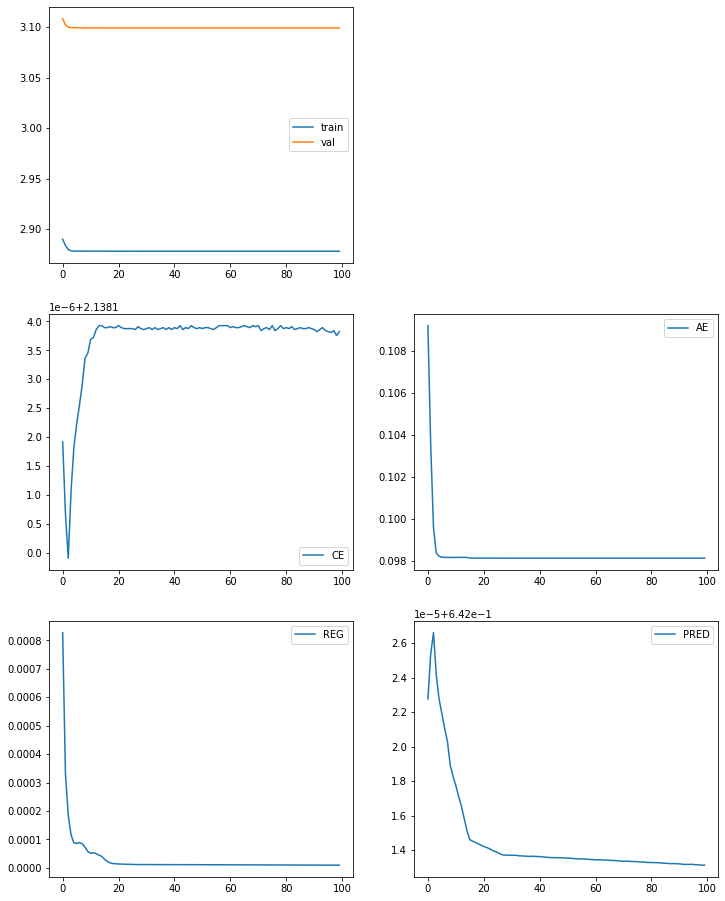

In [29]:
model_HiCI.fit(type_target='binary')

In [30]:
estimate_effect = model_HiCI.cate()

In [31]:
true_effect = treatment_effects[treatment_columns]

In [32]:
abs(true_effect - estimate_effect).mean()

0.17891049653994642

In [33]:
estimate_effect

[0.0016964301,
 -0.0021152943,
 0.0018040836,
 0.013013449,
 0.005123742,
 0.00058092177,
 -0.005083166,
 -0.008560069,
 -0.007613737,
 0.0020929463]

In [34]:
true_effect

array([ 0.11030687, -0.08271754,  0.6076928 , -0.06302303,  0.02740246,
        0.39562028, -0.2273081 , -0.14790916,  0.04690081, -0.08246749])